In [1]:
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from skbio import OrdinationResults
from biom import load_table
from matplotlib_venn import venn2

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Define functions

In [8]:
def get_top_features(table, ordination, component='PC1', 
                     quantile=0.90, pseudocount=0):
    
    #get the loadings
    floadings = ordination.copy()
    floadings.rename(columns={0:"PC1", 1:"PC2", 
                              2:"PC3", 3:"PC4"}, inplace=True)
    table_df = table.copy().to_dataframe()
    top_pc_values = {}
    bottom_pc_values = {}
    beta_l = {}
    
    #sort loadings along each component
    floadings.sort_values(by=component, ascending=False, inplace=True)
    floadings_ = floadings[component].copy()
    #get top and bottom loading quantiles
    top_q = floadings_.quantile(quantile)
    bottom_q = floadings_.quantile(1-quantile)
    top_fts = floadings_[floadings_ >= top_q].index
    bottom_fts = floadings_[floadings_ <= bottom_q].index
    #aggregate the top and bottom features per sample
    num = table_df.loc[top_fts].sum(axis=0)
    num = num+pseudocount
    top_pc_values[component] = num
    
    denom = table_df.loc[bottom_fts].sum(axis=0)
    denom = denom+pseudocount
    bottom_pc_values[component] = denom
    #calculate trajectories
    beta_ = np.log(num) - np.log(denom)
    beta_l[component] = beta_

    #save top and bottom aggregated features as df
    top_fts_df = pd.DataFrame(top_pc_values, index=num.index)
    bottom_fts_df = pd.DataFrame(bottom_pc_values, index=denom.index)
    #save trajectories as df
    beta_df = pd.DataFrame(beta_l, index=num.index)
    #drop any NaN or infinity values
    beta_df = beta_df.sparse.to_dense()
    beta_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    beta_df.dropna(inplace=True)

    return (top_fts_df, bottom_fts_df, beta_df,
            top_fts.tolist(), bottom_fts.tolist())

## Load data

In [3]:
#load rpca results
ord_18S = OrdinationResults.read('../results/joint-rpca/18S_ord.txt')
ord_mag = OrdinationResults.read('../results/joint-rpca/mag_ord.txt')
ord_gene = OrdinationResults.read('../results/joint-rpca/gene_ord.txt')
ord_gene_module = OrdinationResults.read('../results/joint-rpca/gene_module_ord.txt')
ord_metabolite = OrdinationResults.read('../results/joint-rpca/metabolite_ord.txt')
#load joint-rpca results
ord_joint = OrdinationResults.read('../results/joint-rpca/joint_ord.txt')
#load shared metadata
metadata = pd.read_csv('../network/split-matched-data/metadata_knn.tsv', index_col=0, sep='\t')

In [4]:
# import the rest
all_tables = {'18S':'../network/split-matched-data/18S.biom',
              'mag':'../network/split-matched-data/mag.biom',
              'gene':'../network/split-matched-data/gene.biom',
              'gene_module':'../network/split-matched-data/gene_module.biom',
              'metabolite':'../network/split-matched-data/metabolite.biom'}

tables = {}
for tbl_id, tbl_path in all_tables.items():
    tables[tbl_id] = load_table(tbl_path)

In [5]:
#retrieve feature loadings from joint-rpca
joint_features = ord_joint.features

#for 18S, need to make sure features are in the original table
not_in_ord_18S = []
in_ord_18S = []

for id in tables['18S'].ids(axis='observation'):
    if id not in joint_features.index:
        not_in_ord_18S.append(id)
    else:
        in_ord_18S.append(id)
print("Not in ordination results: %i" % len(not_in_ord_18S))
print("In ordination results: %i" % len(in_ord_18S))

#keep only common features
tables['18S'] = tables['18S'].filter(ids_to_keep=in_ord_18S, axis='observation')

Not in ordination results: 42
In ordination results: 5431


## Find overlapping features

In [6]:
pc_to_use = 'PC1'
quantile = 0.90

In [9]:
#find top/bottom features from individual RPCA results
rpca_ord = {'18S': ord_18S, 'mag': ord_mag, 'gene': ord_gene, 
            'gene_module': ord_gene_module, 'metabolite': ord_metabolite}
pc_to_use = 'PC1'
rpca_top_bot_fts = {}

for omic in tables.keys():
    ord_ = rpca_ord[omic].features.copy()
    table_ = tables[omic]
    _, _, _, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                    quantile=quantile, pseudocount=0)
    rpca_top_bot_fts[omic] = top_fts + bottom_fts

#find top features from joint-RPCA results
joint_top_bot_fts = {}

for omic in tables.keys():
    table_ = tables[omic]
    
    if omic == '18S':
        ord_ = joint_features.loc[in_ord_18S]
    else:
        ord_ = joint_features.loc[table_.ids(axis='observation')]

    _, _, _, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                    quantile=quantile, pseudocount=0)
    joint_top_bot_fts[omic] = top_fts + bottom_fts

In [10]:
#find intersecting features
common_omic_fts = {}

for omic in tables.keys():
    common_fts = set(rpca_top_bot_fts[omic]).intersection(joint_top_bot_fts[omic])
    common_omic_fts[omic] = common_fts
    print("Number of intersecting features for %s: %i" % (omic, len(common_fts)))

Number of intersecting features for 18S: 429
Number of intersecting features for mag: 9
Number of intersecting features for gene: 171
Number of intersecting features for gene_module: 19
Number of intersecting features for metabolite: 172


## Plotting

In [ ]:
#rpca_top_bot_fts
#joint_top_bot_fts
#common_omic_fts

In [22]:
#find the average ranks of the intersecting features
avg_ranks_common = {}
for omic in tables.keys():
    ranks_rpca = []
    ranks_joint = []
    
    for ft in common_omic_fts[omic]:
        r_rpca = rpca_top_bot_fts[omic].index(ft) + 1
        r_joint = joint_top_bot_fts[omic].index(ft) + 1
        
        ranks_rpca.append(r_rpca)
        ranks_joint.append(r_joint)
        
    avg_ranks_common[omic] = (np.mean(ranks_rpca), 
                              np.mean(ranks_joint))
    
avg_ranks_common

{'18S': (637.6386946386947, 523.997668997669),
 'mag': (11.333333333333334, 12.0),
 'gene': (251.31578947368422, 247.30994152046785),
 'gene_module': (22.05263157894737, 29.31578947368421),
 'metabolite': (237.07558139534885, 233.4127906976744)}

In [26]:
avg_ranks_rpca_only = {}

for omic in tables.keys():
    ranks_rpca_only = []

    #get features unique to RPCA 
    rpca_only = set(rpca_top_bot_fts[omic]) - set(joint_top_bot_fts[omic])
    print("Number of features unique to RPCA for %s: %i" % (omic, len(rpca_only)))
    for ft in rpca_only:
        r_rpca = rpca_top_bot_fts[omic].index(ft) + 1
        ranks_rpca_only.append(r_rpca)
        
    avg_ranks_rpca_only[omic] = np.mean(ranks_rpca_only)

print()
avg_ranks_rpca_only

Number of features unique to RPCA for 18S: 658
Number of features unique to RPCA for mag: 43
Number of features unique to RPCA for gene: 321
Number of features unique to RPCA for gene_module: 57
Number of features unique to RPCA for metabolite: 296



{'18S': 482.9498480243161,
 'mag': 29.674418604651162,
 'gene': 243.93457943925233,
 'gene_module': 43.98245614035088,
 'metabolite': 233.0033783783784}

In [28]:
avg_ranks_joint_only = {}

for omic in tables.keys():
    ranks_joint_only = []

    #get features unique to RPCA and joint-RPCA
    joint_only = set(joint_top_bot_fts[omic]) - set(rpca_top_bot_fts[omic])
    
    for ft in joint_only:
        r_joint = joint_top_bot_fts[omic].index(ft) + 1
        ranks_joint_only.append(r_joint)
        
    avg_ranks_joint_only[omic] = np.mean(ranks_joint_only)

avg_ranks_joint_only

{'18S': 557.0410334346504,
 'mag': 29.53488372093023,
 'gene': 246.06853582554518,
 'gene_module': 41.56140350877193,
 'metabolite': 235.13175675675674}

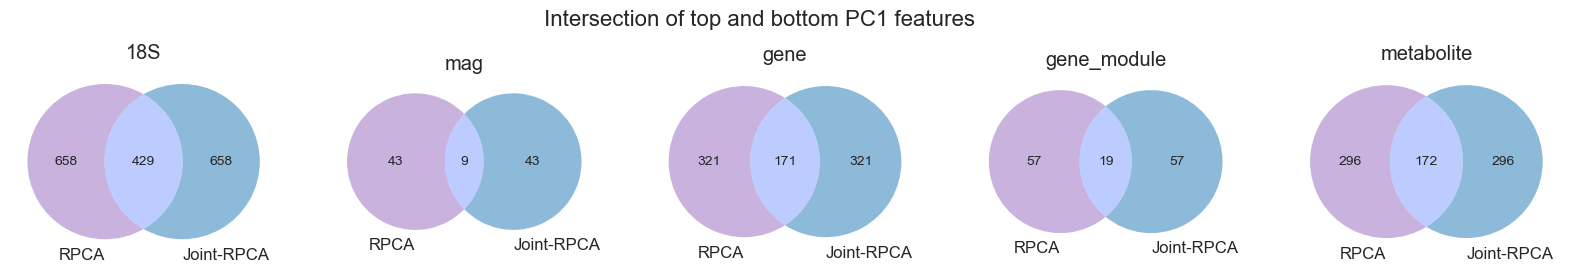

In [11]:
#plot a venn diagram per omic
fig, axn = plt.subplots(1, 5, figsize=(20, 5))
for ax_, omic in zip(axn.flatten(), tables.keys()):

    a = len(rpca_top_bot_fts[omic]) - len(set(common_omic_fts[omic]))
    b = len(set(common_omic_fts[omic]))
    c = len(joint_top_bot_fts[omic]) - len(set(common_omic_fts[omic]))

    venn2(subsets=(a, c, b), set_labels=('RPCA', 'Joint-RPCA'), ax=ax_,
          set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    ax_.set_title(omic)
    plt.suptitle('Intersection of top and bottom {} features'.format(pc_to_use), 
                 fontsize=16, y=0.8)
#plt.tight_layout()
plt.show()